# Calculate mean activations in VGG layers

Perform a forward pass using each image in the dataset and record the mean activation of each neuron separately. Perform the forward pass in batches of 64 to speed up computation and save the results in a separate csv - they will be merged later in a separate step.

## Prepare the image dataset and the network

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as ipyd
import vgg16
import utils
import os
from tqdm import tqdm, tqdm_notebook # progress bar
from __future__ import print_function
from pathlib2 import Path # pathlib2 is a built-in lib in Python 3, unfortunately is external in Python 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
images_root = 'input/tiny-imagenet-200/val/images/'

In [ ]:
# Remove grayscale images to avoid errors due to non-consistent tensor shapes
for image_path in Path(images_root).glob("*.JPEG"):
    img = plt.imread(str(image_path))
    if len(img.shape) < 3:
        print(image_path)
        os.unlink(image_path)

In [3]:
# Import and set up VGG
vgg = vgg16.get_vgg_model()
tf.import_graph_def(vgg['graph_def'], name='vgg')
g = tf.get_default_graph()
layer_names = [op.name for op in g.get_operations()]

x = g.get_tensor_by_name(layer_names[0] + ':0')
output = g.get_tensor_by_name(layer_names[-2] + ':0')

In [9]:
# Get all layers of a given type in the network
op_types = {op.name: op.type for op in g.get_operations()}
conv_layers = [name for (name, type_) in op_types.items() if type_ == 'Conv2D']
relu_layers = [name for (name, type_) in op_types.items() if type_ == 'Relu']
pool_layers = [name for (name, type_) in op_types.items() if type_ == 'MaxPool']
print("Convolutional layers:")
print(conv_layers)
print("\nRelu layers:")
print(relu_layers)
print("\nPooling layers:")
print(pool_layers)

Convolutional layers:
[u'vgg/conv2_1/Conv2D', u'vgg/conv5_3/Conv2D', u'vgg/conv2_2/Conv2D', u'vgg/conv4_3/Conv2D', u'vgg/conv4_2/Conv2D', u'vgg/conv1_1/Conv2D', u'vgg/conv1_2/Conv2D', u'vgg/conv5_1/Conv2D', u'vgg/conv3_2/Conv2D', u'vgg/conv4_1/Conv2D', u'vgg/conv5_2/Conv2D', u'vgg/conv3_3/Conv2D', u'vgg/conv3_1/Conv2D']

Relu layers:
[u'vgg/conv5_1/conv5_1', u'vgg/conv2_2/conv2_2', u'vgg/conv2_1/conv2_1', u'vgg/conv5_2/conv5_2', u'vgg/conv1_2/conv1_2', u'vgg/conv5_3/conv5_3', u'vgg/conv4_2/conv4_2', u'vgg/conv3_2/conv3_2', u'vgg/conv4_3/conv4_3', u'vgg/fc7_relu', u'vgg/fc6_relu', u'vgg/conv1_1/conv1_1', u'vgg/conv3_1/conv3_1', u'vgg/conv3_3/conv3_3', u'vgg/conv4_1/conv4_1']

Pooling layers:
[u'vgg/pool2', u'vgg/pool3', u'vgg/pool1', u'vgg/pool4', u'vgg/pool5']


# Check that we can run VGG and produce reasonable results

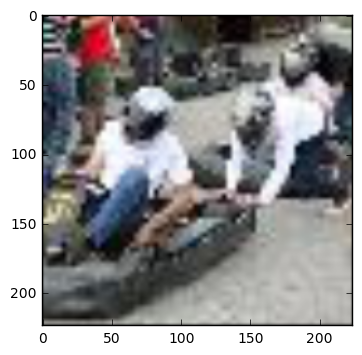

In [4]:
def load_image(img_path):
    img = vgg16.preprocess(plt.imread(img_path)[:, :, 0:3]) # the selection is needed to get rid of the alpha channel
    img_4d = img[np.newaxis]
    return img_4d

#img = load_image('images/abbey_road.png')
img = load_image(images_root + '/val_0.JPEG')
plt.imshow(vgg16.deprocess(img.squeeze()))

In [5]:
def get_layer_depth(layer, feed_dict=None):
    if isinstance(layer, basestring):
        layer = g.get_tensor_by_name(layer)
    layer_shape = tf.Tensor.get_shape(layer)[-1]
    
    # If the shape of the tensor could not be statically determined then try to evaluate it dynamically if 
    # a feed_dict was passed, or raise an exception
    if layer_shape.value is None:
        if feed_dict is not None:
            layer_shape = tf.shape(layer).eval(feed_dict=feed_dict)[-1] # Avoid evaluating a full graph just to get a shape
        else:
            raise Exception("Layer depth can not be computed from the static graph, please pass a feed_dict to eval it. "
                            "(Are you sure you have passed a layer with a depth dimension?)")
    return layer_shape

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    depth = get_layer_depth('vgg/conv5_3/conv5_3:0')
    # depth = get_layer_depth('vgg/conv5_3/conv5_3:0', feed_dict={x: img})
    print(depth)

512


In [6]:
# VGG uses dropout. We want to make sure that results are always the same
# so we need to avoid using dropout during prediction. 
def add_no_droupout(feed_dict):
    feed_dict['vgg/dropout_1/random_uniform:0'] = [[1.0] * 4096]
    feed_dict['vgg/dropout/random_uniform:0'] = [[1.0] * 4096]
    return feed_dict

In [7]:
with tf.Session(graph=g) as sess:
    feed_dict = add_no_droupout({x: img})
    res = output.eval(feed_dict=feed_dict)[0]

print([(res[idx], vgg['labels'][idx])
       for idx in res.argsort()[-5:][::-1]])

[(0.38699836, (856, 'n04428191 thresher, thrasher, threshing machine')), (0.17740867, (612, 'n03599486 jinrikisha, ricksha, rickshaw')), (0.16405806, (450, 'n02860847 bobsled, bobsleigh, bob')), (0.158335, (690, 'n03868242 oxcart')), (0.023386642, (653, 'n03764736 milk can'))]


# Save the mean activation for each layer/filter/image combination

Iterate over all (selected) layers and each filter in those layers. For each of these, load all images in batches and calculate the mean activation. Finally save the the results in a .csv so we can later collect them in a separate process.
 - Originally I loaded all images only once and calculated all activations for them while they were still in memory. It turns out that creating the partial graphs for each image separately takes a very long time, so that method was painfully slow. I ended up changing the nesting of the loops, so processing the images became the innermost loop, which means that each partial graph is only created once, but all images are loaded multiple times from disk (most likely they are cached in memory though). I also added processing the images in batches, so I could better use multiple cores/the GPU on an Amazon instance. These two changes resulted in much faster processing speeds.
 - Instead of simply loading the images into memory, I wanted to make that part of the graph as well, so I re-wrote loading as a set of Tensorflow operations instead of using Numpy. In the end I did not have enough time to figure out how to set the tensor that is the result of the batch iterator directly to the input of VGG, so I ended up loading the batch in one `sess.run` call and feeding it to VGG in a separate `sess.run` call, which is probably a bit slower than it could be.
 - All ops for a single layer are in a single `sess.run` call (instead of looping through them one by one), which should mean that all calculations before the given layer are only performed once. I have not verified this though.
 - Results are saves in separate files per batch, so partial results are saved even if something goes wrong. This also makes it easy to make the code parallel later.

In [10]:
images = [str(p.name) for p in Path(images_root).glob('*.JPEG')]
print("{} images found".format(len(images)))
layers = relu_layers # Select only the Relu layers for processing now
print("\nProcessing the following layers: ")
print(layers)

9832 images found

Processing the following layers: 
[u'vgg/conv5_1/conv5_1', u'vgg/conv2_2/conv2_2', u'vgg/conv2_1/conv2_1', u'vgg/conv5_2/conv5_2', u'vgg/conv1_2/conv1_2', u'vgg/conv5_3/conv5_3', u'vgg/conv4_2/conv4_2', u'vgg/conv3_2/conv3_2', u'vgg/conv4_3/conv4_3', u'vgg/fc7_relu', u'vgg/fc6_relu', u'vgg/conv1_1/conv1_1', u'vgg/conv3_1/conv3_1', u'vgg/conv3_3/conv3_3', u'vgg/conv4_1/conv4_1']


In [10]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def _parse_function(filename):
    image_string = tf.read_file(filename)
    
    # image_decoded = tf.image.decode_image(image_string)
    # https://github.com/tensorflow/tensorflow/issues/9356
    # `decode_image` fails (on TF 1.3), `decode_jpeg` works fine.
    image_decoded = tf.image.decode_jpeg(image_string)
    
    image_resized = tf.image.resize_images(image_decoded, [224, 224])
    #image_resized = vgg16.preprocess(image_decoded)
    return filename, image_resized

# A vector of filenames.
image_paths = [images_root + i for i in images]
filenames = tf.constant(image_paths)

dataset = tf.contrib.data.Dataset.from_tensor_slices(filenames)
dataset = dataset.map(_parse_function)
batched_dataset = dataset.batch(64)

In [ ]:
with tf.Session(graph=g) as sess:
    for layer_idx, layer_name in enumerate(layers):
        layer_tensor_name = layer_name + ':0'
        layer = g.get_tensor_by_name(layer_tensor_name)
        print()
        print("Layer {}".format(layer_name))

        mean_activations = []
        #for filter_number in range(min(get_layer_depth(layer), 5)): # Max 5 filters for debugging
        for filter_number in range(get_layer_depth(layer)):
            # save the average activation of that filter
            if len(layer.shape) == 4:
                mean_activation_op = tf.reduce_mean(layer[:, :, :, filter_number], axis=[1, 2])
            elif len(layer.shape) == 2:
                mean_activation_op = layer[:, filter_number]
            else:
                raise Exception("Unknown layer type")
            mean_activations.append(mean_activation_op)
        mean_activations = tf.stack(mean_activations)
        image_iterator = batched_dataset.make_one_shot_iterator()
        
        batch_index = 0
        while True:
            if batch_index % 100 == 0:
                print()
                print(batch_index, end="")
            print(".", end="")
            try:
                image_filenames, image_data = sess.run(image_iterator.get_next())
                batch_index += 1
            except tf.errors.OutOfRangeError: # End of the image dataset
                break
            mean_activations_val = sess.run(mean_activations, feed_dict=add_no_droupout({x: image_data}))
            result = []
            for filter_number in xrange(mean_activations_val.shape[0]):
                for image_index in xrange(mean_activations_val.shape[1]):
                    result.append((image_filenames[image_index], 
                                   layer_name, 
                                   filter_number, 
                                   mean_activations_val[filter_number, image_index]))
            df = pd.DataFrame(result, columns=['image', 'layer', 'filter', 'mean_activation'])
            df.to_csv("output/l{}_b{}_activations.csv".format(layer_idx, batch_index))